<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Arcs-and-Routes" data-toc-modified-id="Arcs-and-Routes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Arcs and Routes</a></span><ul class="toc-item"><li><span><a href="#Arcs" data-toc-modified-id="Arcs-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Arcs</a></span></li><li><span><a href="#Routes-(OD-+-volume)" data-toc-modified-id="Routes-(OD-+-volume)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Routes (OD + volume)</a></span></li></ul></li><li><span><a href="#Network-Graph" data-toc-modified-id="Network-Graph-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Network Graph</a></span><ul class="toc-item"><li><span><a href="#Create-graph" data-toc-modified-id="Create-graph-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Create graph</a></span></li><li><span><a href="#Find-shortest-paths" data-toc-modified-id="Find-shortest-paths-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Find shortest paths</a></span></li><li><span><a href="#Convert-lists-of-nodes-to-path-node-sequence" data-toc-modified-id="Convert-lists-of-nodes-to-path-node-sequence-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Convert lists of nodes to path-node sequence</a></span></li></ul></li></ul></div>

In [1]:
import os
import pandas as pd
import networkx as nx
from LH_MODULE_CONFIG import SCRATCH_FOLDER, INPUT_FOLDER
%matplotlib inline

Active scenario: Baseline


## Arcs and Routes

### Arcs

In [2]:
arcs = pd.read_csv(os.path.join(SCRATCH_FOLDER, 'Arcs_with_lengths.csv'))

In [3]:
arcs.head()

,arc_id,from_node_id,to_node_id,drive_dist_meters,drive_dist_km
0,1,1,76,9089,9
1,2,76,75,16778,17
2,3,75,2,21943,22
3,4,2,74,30458,30
4,5,74,73,2815,3


### Routes (OD + volume)

In [6]:
routes = pd.read_csv(os.path.join(SCRATCH_FOLDER, 'Routes.csv'))

In [7]:
routes.head()

,route_id,orig_node_id,dest_node_id,volume,path_id
0,0,13,18,40940.5,0
1,1,18,13,40940.5,1
2,2,12,13,3447.5,2
3,3,12,18,3447.5,3
4,4,25,13,245.0,4


## Network Graph

### Create graph

In [8]:
truck_network = nx.from_pandas_edgelist(arcs, 
                                        source='from_node_id', 
                                        target='to_node_id', 
                                        edge_attr=['arc_id','drive_dist_meters','drive_dist_km']
                                       )

In [9]:
truck_network[11][40]

{'arc_id': 17, 'drive_dist_meters': 41960, 'drive_dist_km': 42}

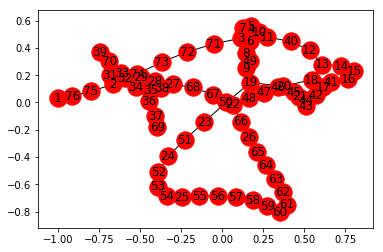

In [10]:
nx.draw_networkx(truck_network)

### Find shortest paths

In [20]:
paths_od = routes[['path_id', 'orig_node_id', 'dest_node_id']]

In [21]:
paths_od.head()

,path_id,orig_node_id,dest_node_id
0,0,13,18
1,1,18,13
2,2,12,13
3,3,12,18
4,4,25,13


In [27]:
paths_od['node_list'] = paths_od.apply(lambda row: nx.shortest_path(truck_network, 
                                                                    source=row['orig_node_id'], 
                                                                    target=row['dest_node_id'], 
                                                                    weight='drive_dist_meters'), 
                                 axis=1)

C:\Users\Guozhen Li\.conda\envs\CHIP-MDHD\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [28]:
paths_od.head()

,path_id,orig_node_id,dest_node_id,node_list
0,0,13,18,"[13, 18]"
1,1,18,13,"[18, 13]"
2,2,12,13,"[12, 13]"
3,3,12,18,"[12, 13, 18]"
4,4,25,13,"[25, 54, 53, 52, 24, 51, 23, 50, 19, 20, 18, 13]"


### Convert lists of nodes to path-node sequence

In [35]:
nodes_seq = paths_od\
                .set_index('path_id')\
                .apply(lambda row: pd.Series(row['node_list']), axis=1)\
                .stack()\
                .apply(int)\
                .to_frame(name='node_id')\
                .rename_axis(['path_id', 'node_seq'], axis='index')\
                .reset_index(level='node_seq')

In [36]:
nodes_seq.head(10)

,node_seq,node_id
path_id,,
0,0,13
0,1,18
1,0,18
1,1,13
2,0,12
2,1,13
3,0,12
3,1,13
3,2,18


In [37]:
paths = paths_od\
                .set_index('path_id')\
                .join(nodes_seq)\
                .drop('node_list', axis=1)

In [38]:
paths.head(10)

,orig_node_id,dest_node_id,node_seq,node_id
path_id,,,,
0,13,18,0,13
0,13,18,1,18
1,18,13,0,18
1,18,13,1,13
2,12,13,0,12
2,12,13,1,13
3,12,18,0,12
3,12,18,1,13
3,12,18,2,18


In [39]:
paths.to_csv(os.path.join(SCRATCH_FOLDER, 'Paths.csv'))